In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc

In [2]:
# import the formatted dataset
df = pd.read_csv('../data/accident_vehicle_2015_formatted.csv')

In [3]:
# create a function to print the confusion matrix
def print_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.set_context('talk')
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

In [4]:
# create a function to plot the ROC curve and print the AUC
def print_roc_auc(y_test, y_pred_proba):
    fpr, tpr, thresh = roc_curve(y_test, y_pred_proba, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    sns.set_context('talk')
    sns.set_style('darkgrid')
    plt.figure(figsize=(12,8))
    plt.plot(fpr, tpr, label=str(roc_auc))
    plt.legend()
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

In [5]:
# create a function to print a correlation matrix heat map
def print_corr(df, annotate=False):
    df_corr = df.corr(method='kendall', numeric_only=True)

    # display a heatmap of the correlation matrix
    sns.set(rc={"figure.figsize":(20, 16)})
    sns.heatmap(df_corr, annot=annotate, annot_kws={'size': 12}, cmap='coolwarm', vmin=-1, vmax=1)
    plt.show()

In [6]:
# scale the numerical features
cols_to_rescale = ['number_of_motor_vehicles_in_transport_mvit',
                   'number_of_occupants',
                   'day_of_crash',
                   'total_lanes_in_roadway',
                   'number_of_forms_submitted_for_persons_not_in_motor_vehicles',
                   'number_of_persons_not_in_motor_vehicles_in_transport_mvit',
                   'number_of_persons_in_motor_vehicles_in_transport_mvit',
                   'latitude',
                   'longitude',
                   'light_condition',
                   'number_of_drunk_drivers']

scaler = StandardScaler()
scaler.fit(df[cols_to_rescale])
rescaled_cols = scaler.transform(df[cols_to_rescale])

# create a separate dataframe
df_scaled = df.drop((['fatalities_in_vehicle', 'number_of_fatalities']), axis=1).copy()
df_scaled[cols_to_rescale] = rescaled_cols.astype('float32')

In [7]:
# cosine transform the month, day of week and hour features since they're cyclical
df_scaled['month_of_crash'] = np.cos(2 * np.pi * df_scaled['month_of_crash'] / 12)
df_scaled['day_of_week'] = np.cos(2 * np.pi * df_scaled['day_of_week'] / 7)
df_scaled['hour_of_crash'] = np.cos(2 * np.pi * df_scaled['hour_of_crash'] / 24)

df_scaled['month_of_crash'] = df_scaled['month_of_crash'].astype('float32')
df_scaled['day_of_week'] = df_scaled['day_of_week'].astype('float32')
df_scaled['hour_of_crash'] = df_scaled['hour_of_crash'].astype('float32')

## PCA analysis:

In [8]:
# perform PCA analysis
pca = PCA(n_components=15)

pca_results = pca.fit(df_scaled)

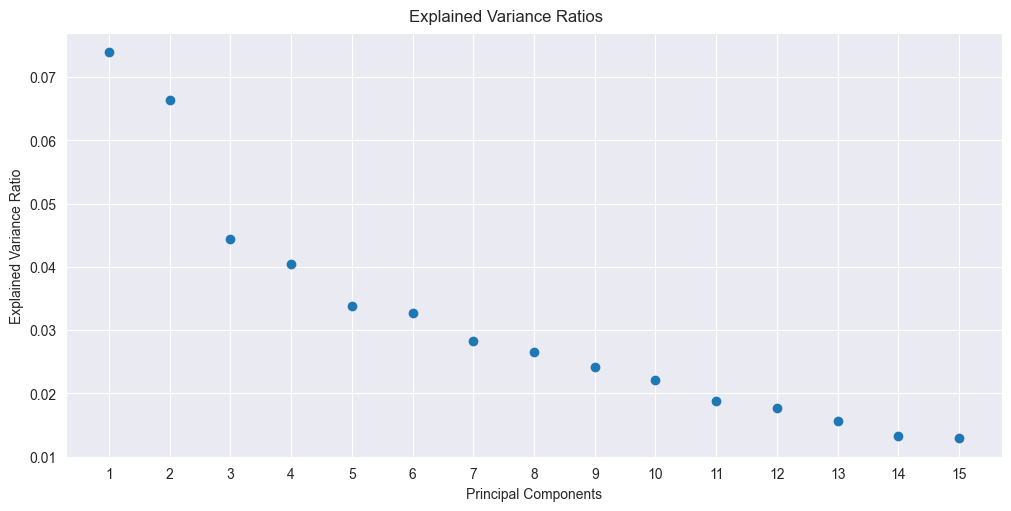

In [9]:
# plot the variance ratios
sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(10,5), layout='constrained')
fig.suptitle("Explained Variance Ratios")
ax.scatter(x=[i+1 for i in range(len(pca_results.explained_variance_ratio_))],
            y=pca_results.explained_variance_ratio_)
ax.set_xlabel("Principal Components")
ax.set_xticks([i+1 for i in range(len(pca_results.explained_variance_ratio_))])
plt.ylabel("Explained Variance Ratio")
plt.show()

In [10]:
# see how much of the top components explain the data
print('Top 15 components explains ', (pca_results.explained_variance_ratio_.sum() * 100), '% of the data', sep="")

Top 15 components explains 47.06418085544434% of the data


## Model using RFE, CV and XGBClassifier:

In [11]:
# use recursive feature elimination with cross-validation to get a ranking of the features in terms of importance
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df['fatalities_in_vehicle'], test_size=0.2, random_state=21)

xgbc_model = XGBClassifier(objective='binary:logistic')

rfe_cv = RFECV(estimator=xgbc_model,
               step=50,
               cv=StratifiedKFold(3),
               scoring='accuracy',
               n_jobs=-1)

rfe_cv.fit(X_train, y_train)

RFECV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
      estimator=XGBClassifier(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...),
      n_jobs=-1, scoring='accuracy', step=50)

In [12]:
# print the number of optimal features that RFE found
print('Optimal number of features:', rfe_cv.n_features_)

Optimal number of features: 193


In [13]:
X_train.columns[rfe_cv.support_]

Index(['number_of_motor_vehicles_in_transport_mvit', 'number_of_occupants',
       'hit_and_run', 'vehicle_trailing', 'rollover', 'fire_occurrence',
       'speeding_related', 'driver_drinking',
       'number_of_forms_submitted_for_persons_not_in_motor_vehicles',
       'number_of_persons_not_in_motor_vehicles_in_transport_mvit',
       ...
       'state_name_Texas', 'land_use_name_Rural',
       'functional_system_name_Interstate', 'functional_system_name_Local',
       'relation_to_junction_specific_location_name_Driveway Access Related',
       'type_of_intersection_Not an Intersection',
       'atmospheric_conditions_1_name_Rain',
       'atmospheric_conditions_name_Fog_ Smog_ Smoke',
       'atmospheric_conditions_name_Rain',
       'related_factors_crash_level_1_name_Motor Vehicle (In Transport 1983-2004) Struck By Falling Cargo or\nSomething That Came Loose From or Something That Was Set in Motion By\na Vehicle\n(Since 1983)'],
      dtype='object', length=193)

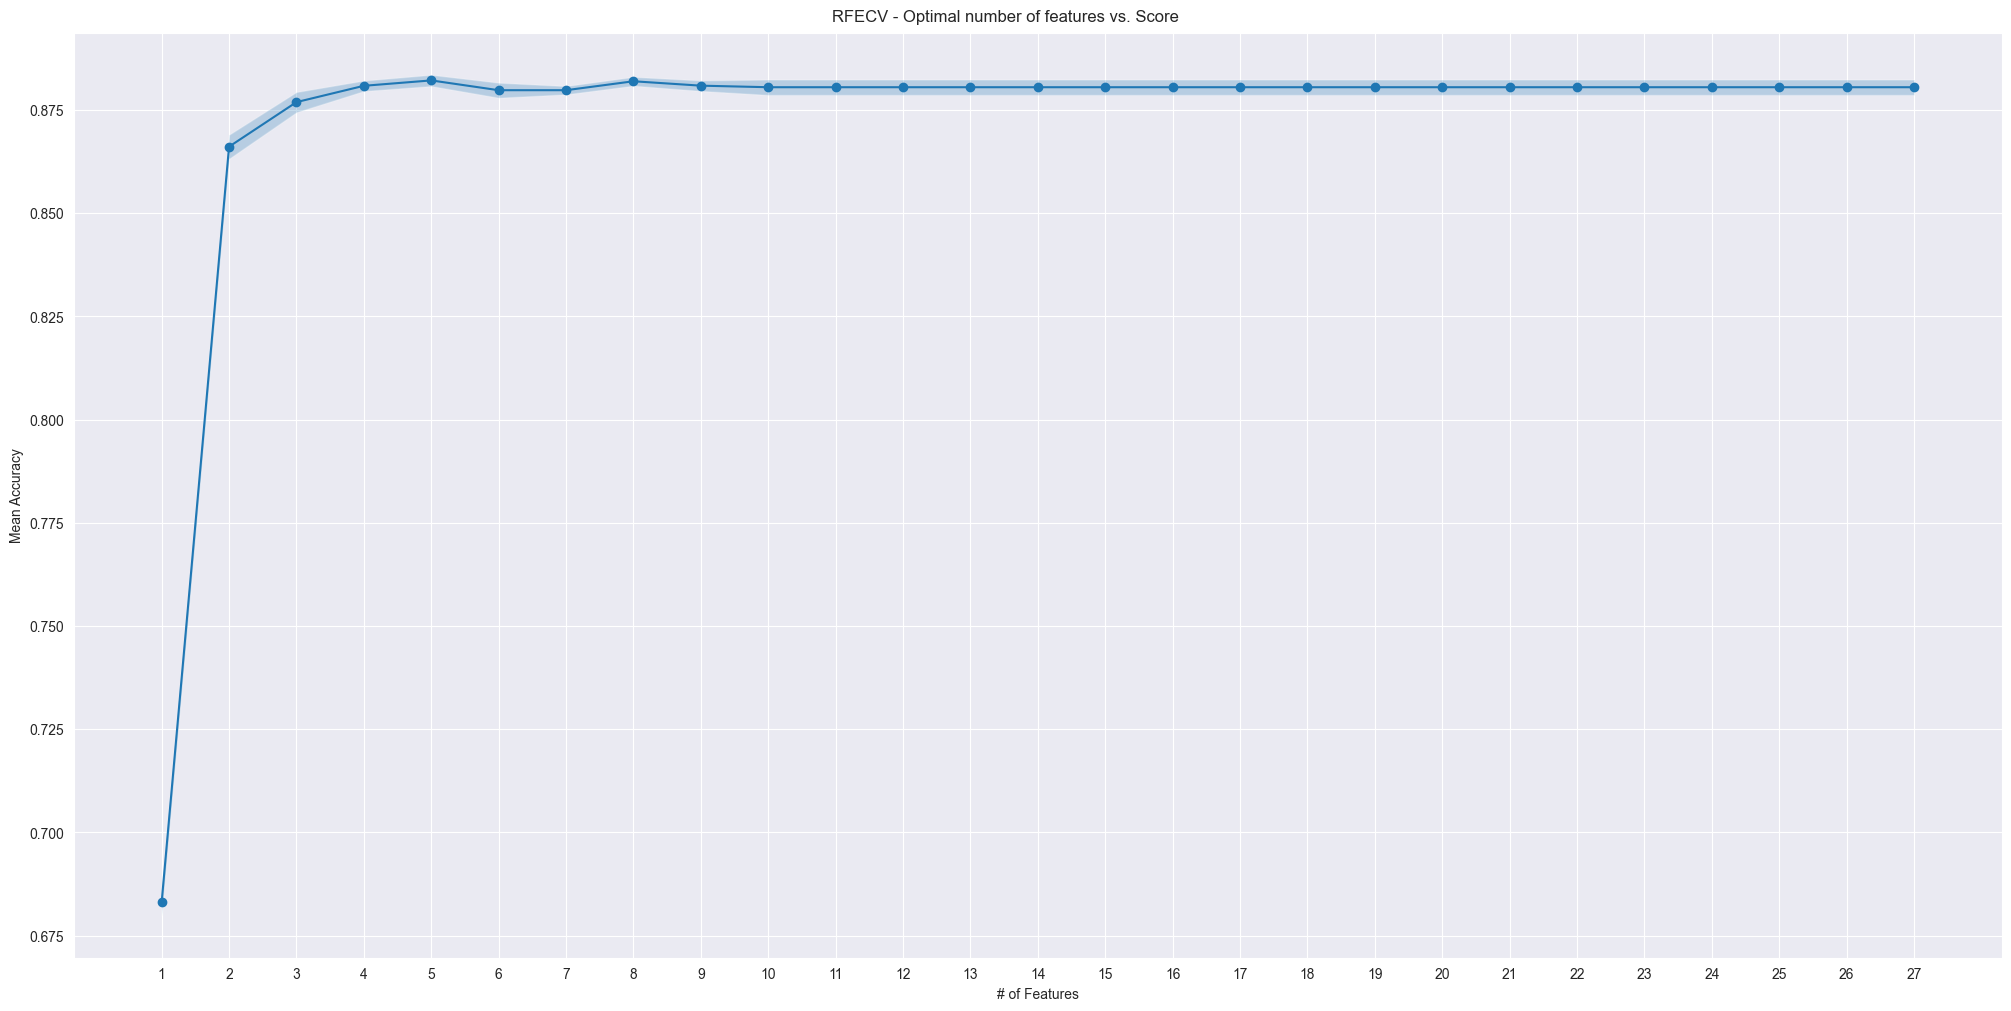

In [14]:
# print the cross-validation scores for each level of features being used
cv_scores = rfe_cv.cv_results_['mean_test_score']
cv_scores_std = rfe_cv.cv_results_['std_test_score']
number_of_features = np.arange(1, len(cv_scores) + 1, 1)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,10), layout='constrained')
fig.suptitle("RFECV - Optimal number of features vs. Score")
plt.xlabel("# of Features")
ax.set_xticks([i for i in number_of_features])
plt.ylabel("Mean Accuracy")
plt.plot(number_of_features, cv_scores, 'o-')
plt.fill_between(number_of_features, cv_scores - cv_scores_std, cv_scores + cv_scores_std, alpha=0.25)
plt.show()

In [15]:
# Seems like 8-12 features gives the optimal amount of accuracy

## Model using XGB feature importance:

In [16]:
# use XGBoost and feature importance to get the most important features
xgb_all = XGBClassifier(objective='binary:logistic', n_jobs=-1)
xgb_all.fit(X_train, y_train)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

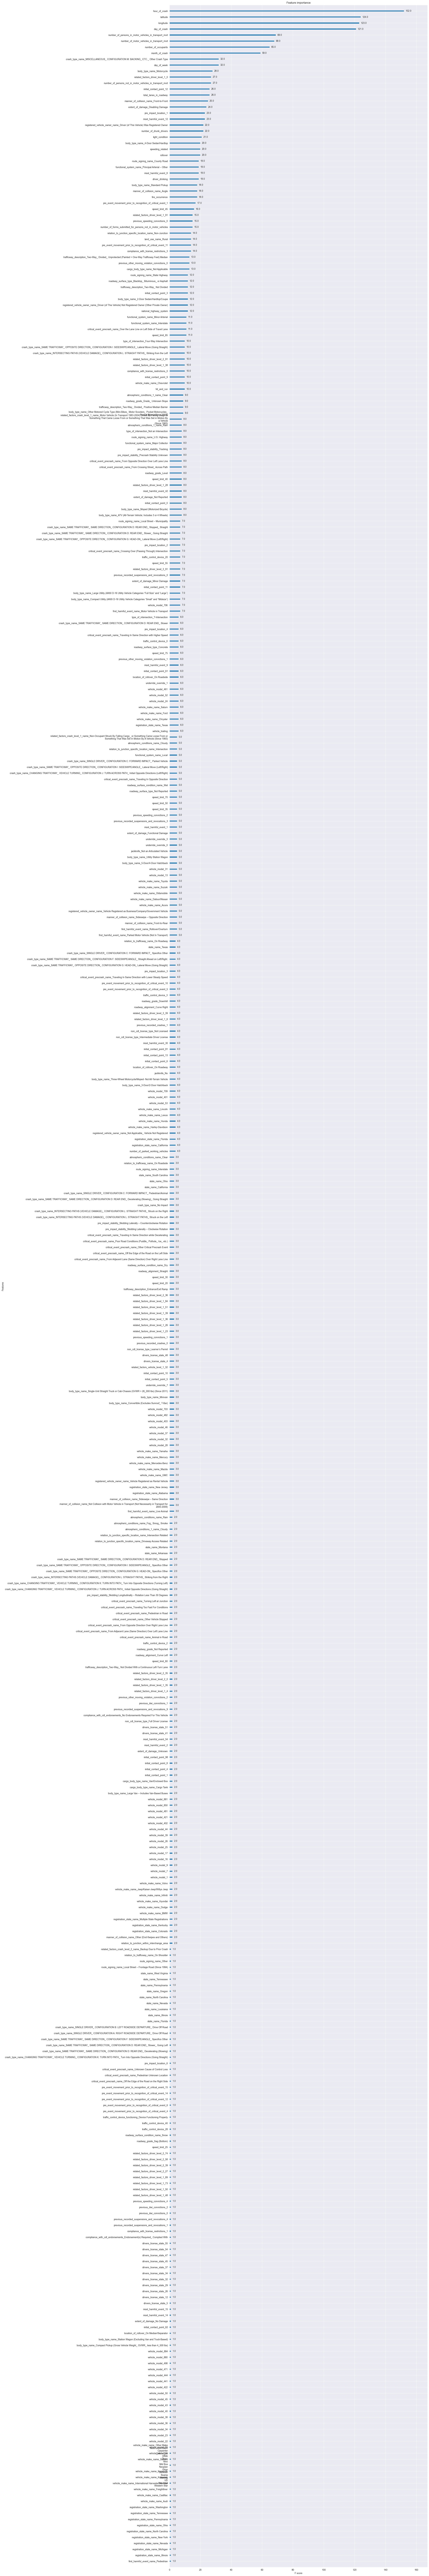

In [17]:
# use the plot_importance function to plot the most important features
fig, ax = plt.subplots(figsize=(20,200))
plot_importance(xgb_all, ax=ax)
plt.show()

In [18]:
# save predictions from the test set
y_pred = xgb_all.predict(X_test)
y_pred_proba = xgb_all.predict_proba(X_test)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

Classification report
               precision    recall  f1-score   support

       False       0.87      0.87      0.87      3439
        True       0.89      0.88      0.88      3833

    accuracy                           0.88      7272
   macro avg       0.88      0.88      0.88      7272
weighted avg       0.88      0.88      0.88      7272



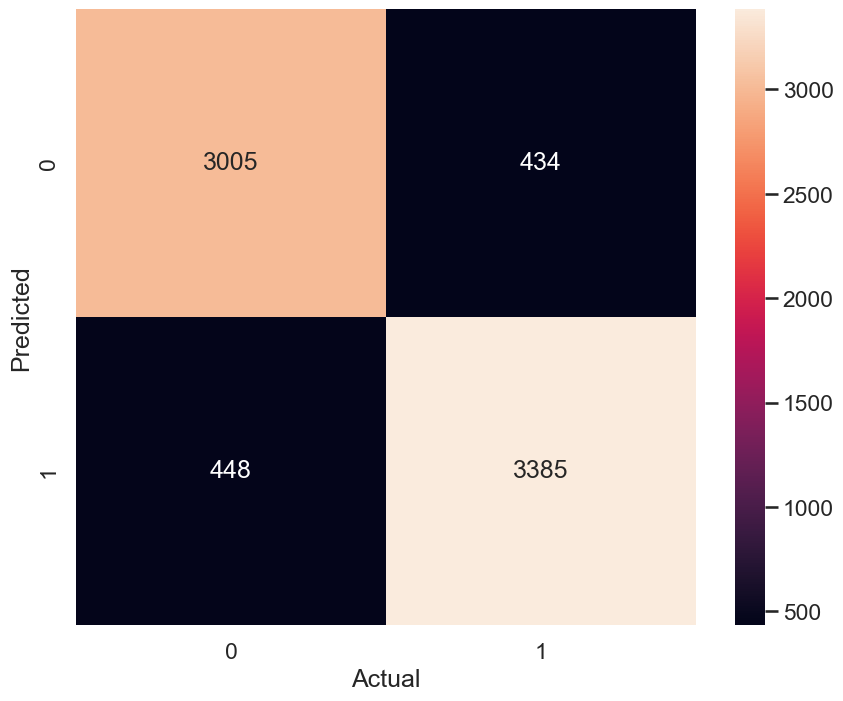

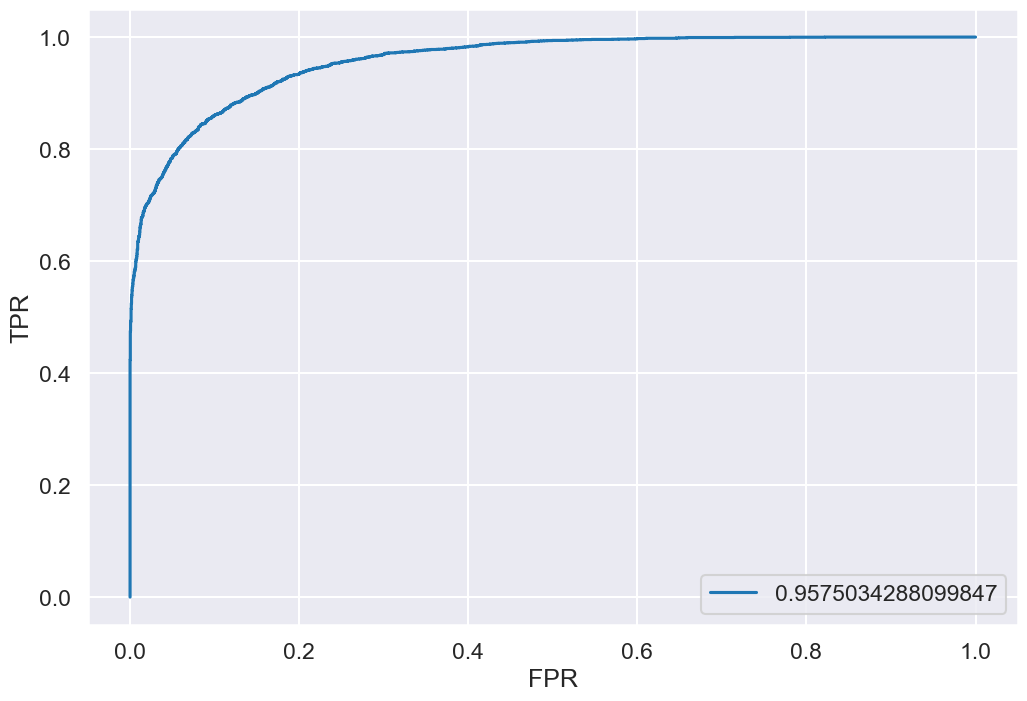

In [19]:
# evaluate the results
print('Classification report\n', classification_report(y_test, y_pred))
print_cm(y_test, y_pred)

# plot the ROC curve and print the AUC
print_roc_auc(y_test, y_pred_proba[:, 1])

In [20]:
# get a dict of the features sorted by feature importance
xgb_all_booster = xgb_all.get_booster()
importance_dict = xgb_all_booster.get_score(importance_type='weight')
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
xgb_feats = [feature[0] for feature in sorted_importance]

In [21]:
# save the 15 most important features
X = df_scaled[xgb_feats[:15]]
y_class = df['fatalities_in_vehicle']
y_reg = df['number_of_fatalities']

In [22]:
# create another train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=21)

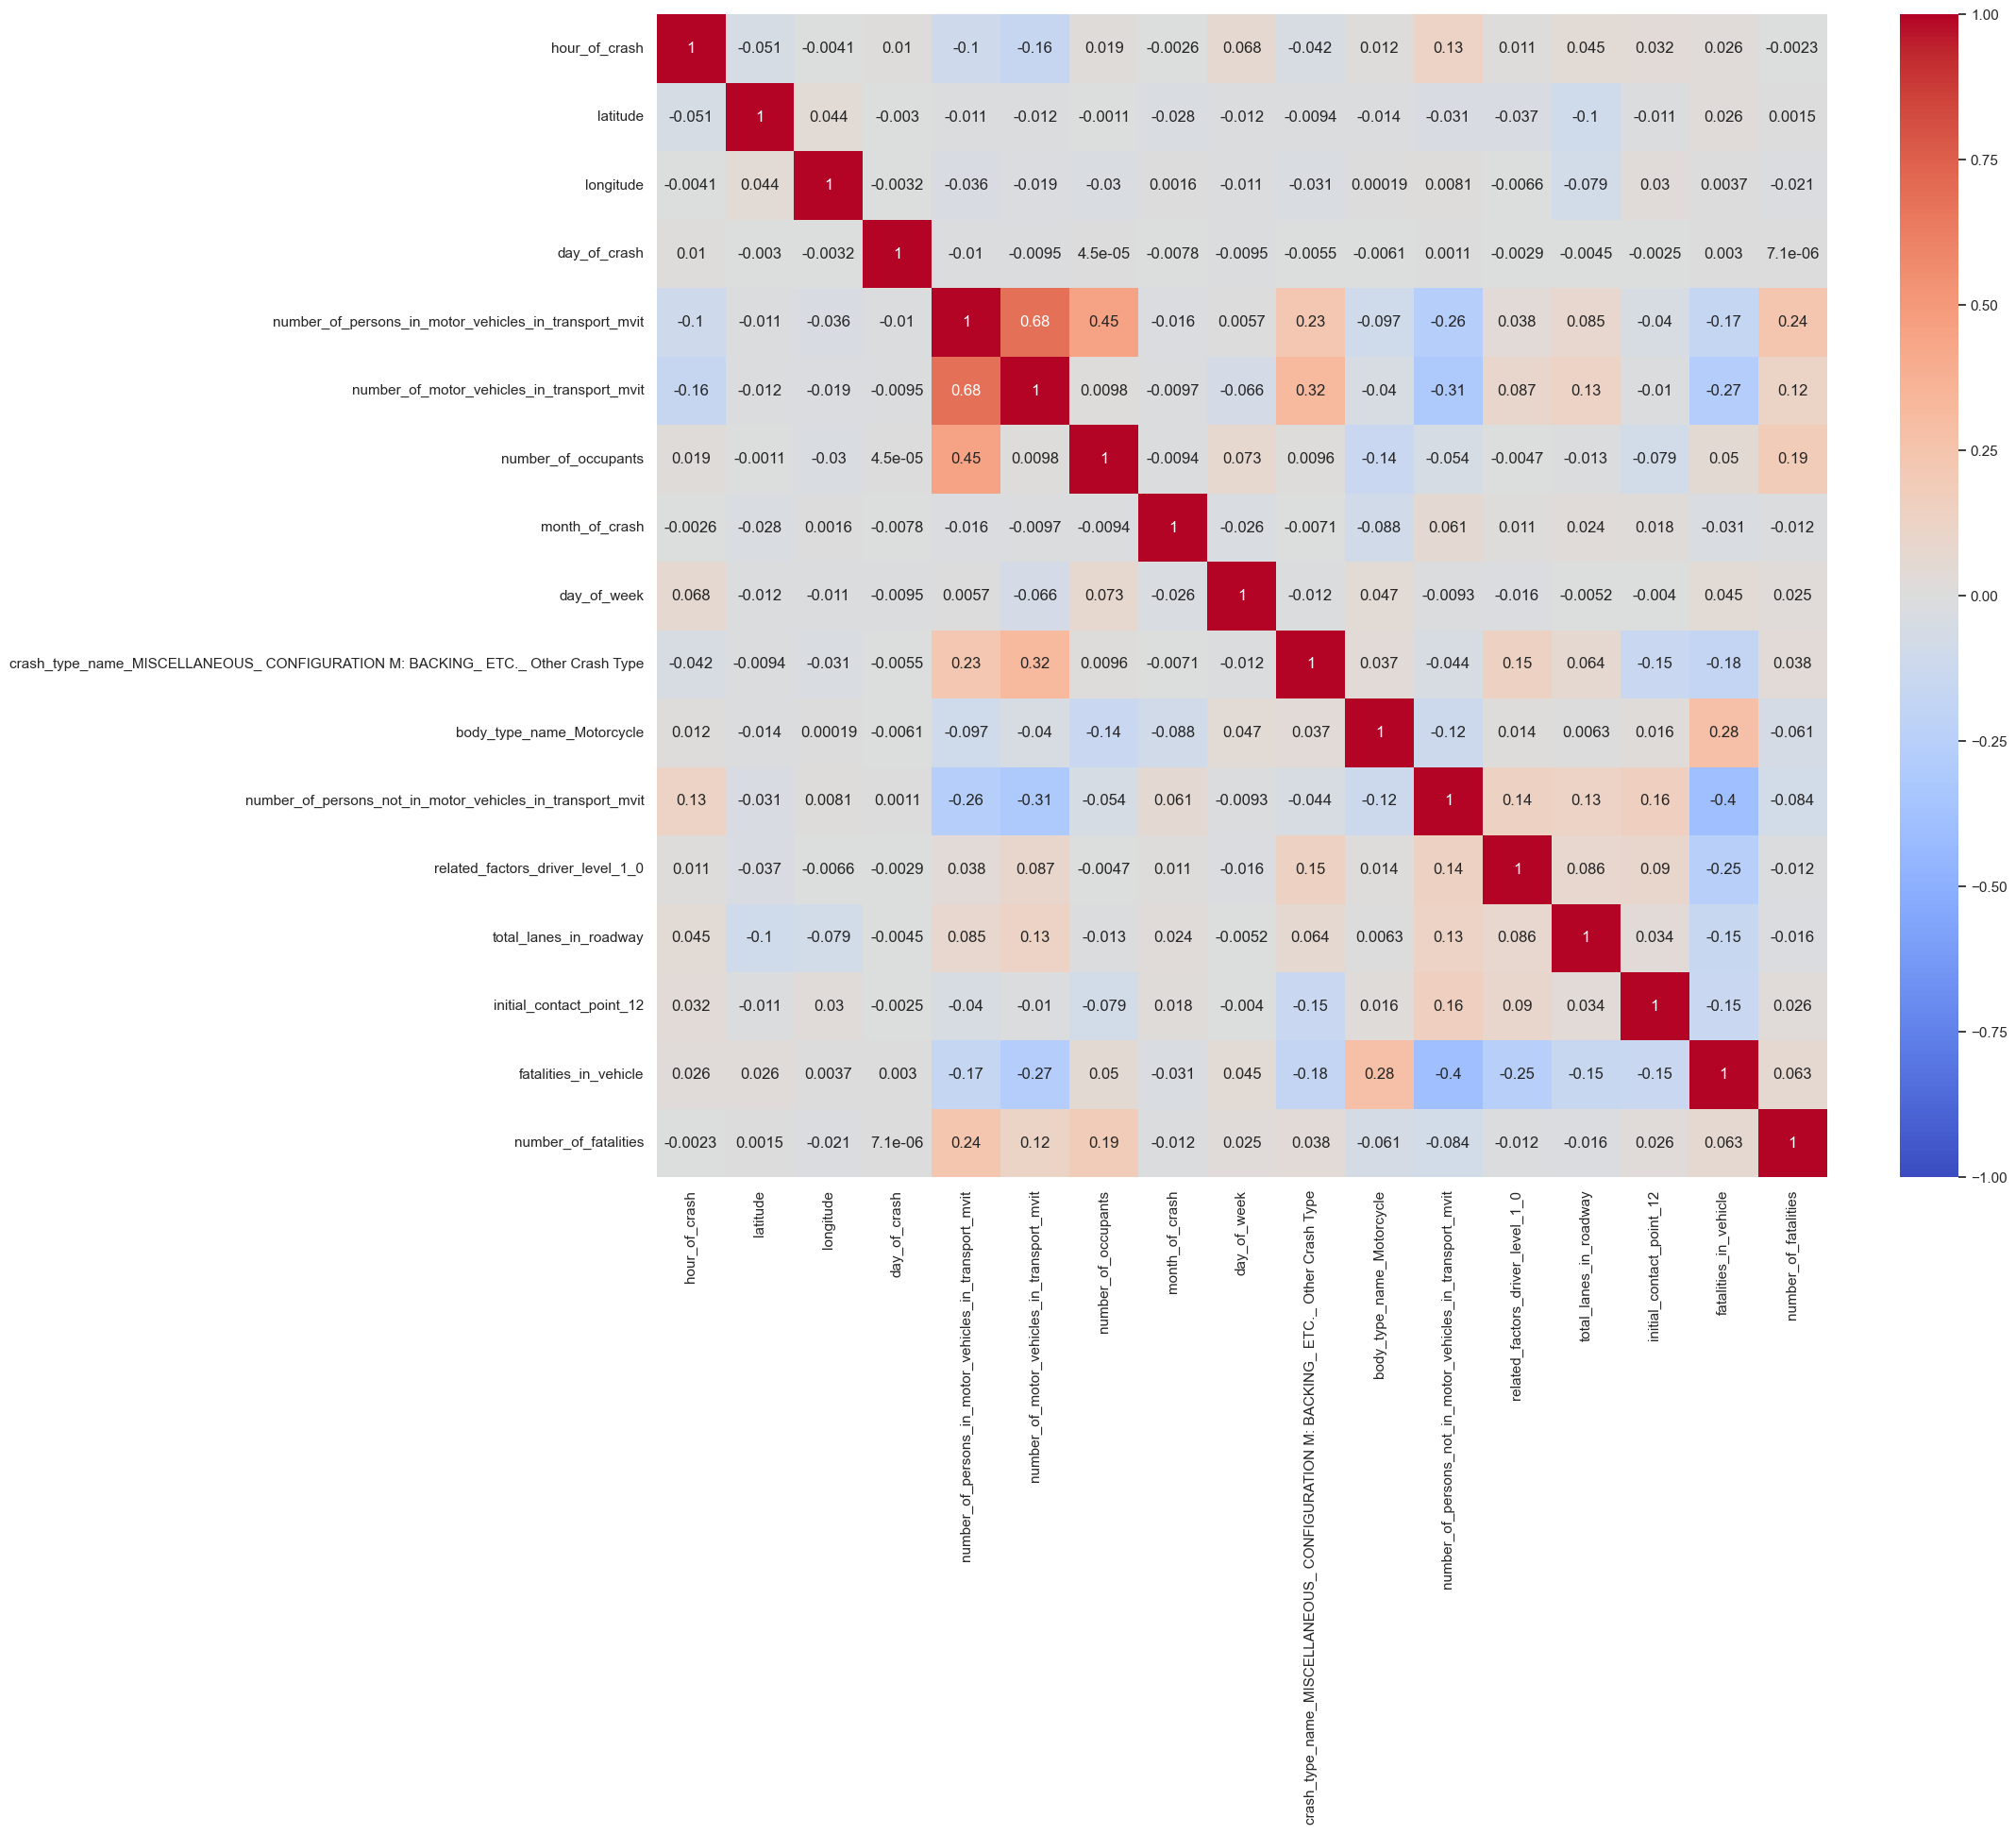

In [23]:
# print correlation matrix heat map
print_corr(pd.concat([X, y_class, y_reg], axis=1), annotate=True)

In [24]:
# fit a model
xgb_model = XGBClassifier(objective='binary:logistic', n_jobs=-1)
xgb_model.fit(X_train, y_train)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [25]:
# save predictions from the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

Classification report
               precision    recall  f1-score   support

       False       0.75      0.82      0.79      3439
        True       0.83      0.76      0.79      3833

    accuracy                           0.79      7272
   macro avg       0.79      0.79      0.79      7272
weighted avg       0.79      0.79      0.79      7272



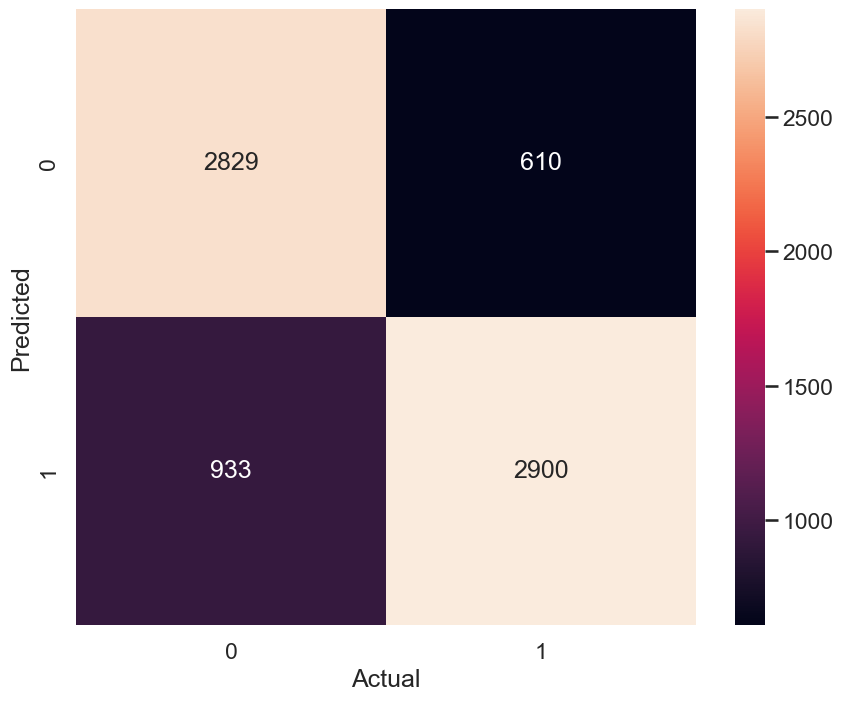

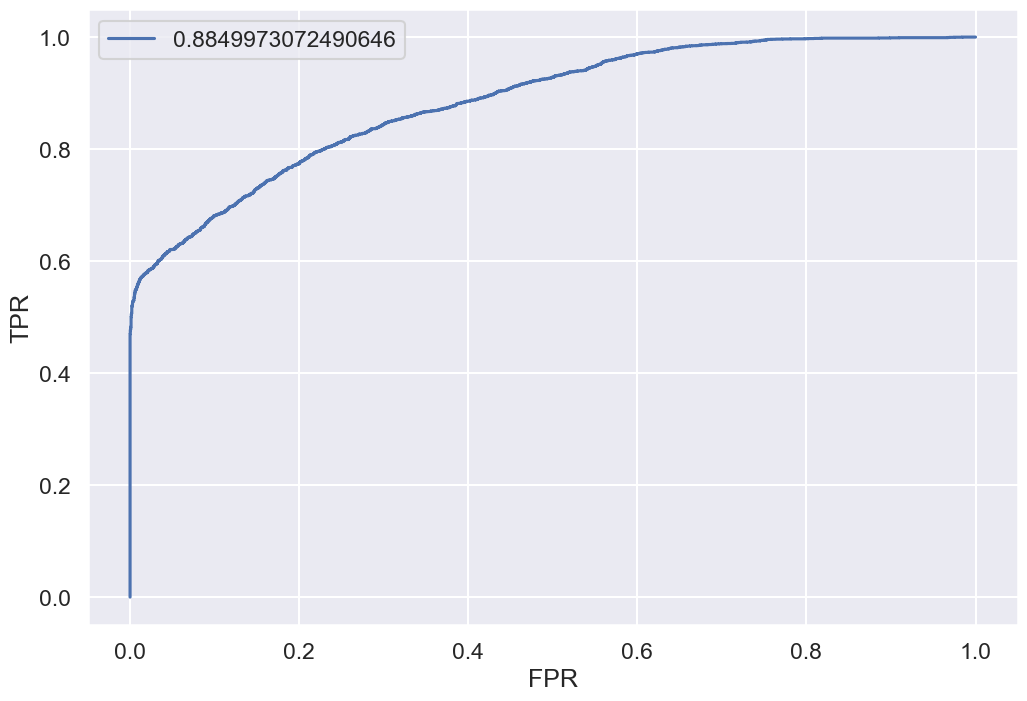

In [26]:
# evaluate the results
print('Classification report\n', classification_report(y_test, y_pred))
print_cm(y_test, y_pred)

# plot the ROC curve and print the AUC
print_roc_auc(y_test, y_pred_proba[:, 1])

## Model using variance threshold:

In [27]:
# use variance threshold to get a set of features that contribute the most to the variance of data
vt = VarianceThreshold(0.20)
df_vt = vt.fit_transform(df_scaled)

In [28]:
# save the features that met the threshold
important_features = df_scaled.columns[vt.get_support()]
print('Features:\n', important_features, '\nNumber of features:', len(important_features))

Features:
 Index(['number_of_motor_vehicles_in_transport_mvit', 'number_of_occupants',
       'day_of_crash', 'month_of_crash', 'hour_of_crash',
       'total_lanes_in_roadway',
       'number_of_forms_submitted_for_persons_not_in_motor_vehicles',
       'number_of_persons_not_in_motor_vehicles_in_transport_mvit',
       'number_of_persons_in_motor_vehicles_in_transport_mvit', 'day_of_week',
       'national_highway_system', 'latitude', 'longitude', 'light_condition',
       'number_of_drunk_drivers',
       'first_harmful_event_name_Motor Vehicle in Transport',
       'manner_of_collision_name_Not Collision with Motor Vehicle in Transport (Not Necessarily in Transport for\n2005-2009)',
       'registered_vehicle_owner_name_Driver (of This Vehicle) Not Registered Owner (Other Private Owner)',
       'registered_vehicle_owner_name_Driver (of This Vehicle) Was Registered Owner',
       'body_type_name_4-Door Sedan/Hardtop', 'initial_contact_point_12',
       'most_harmful_event_12', 'com

In [29]:
# save X and y based on the features that met the threshold of the Variance Threshold
X_vt = df_scaled[important_features]

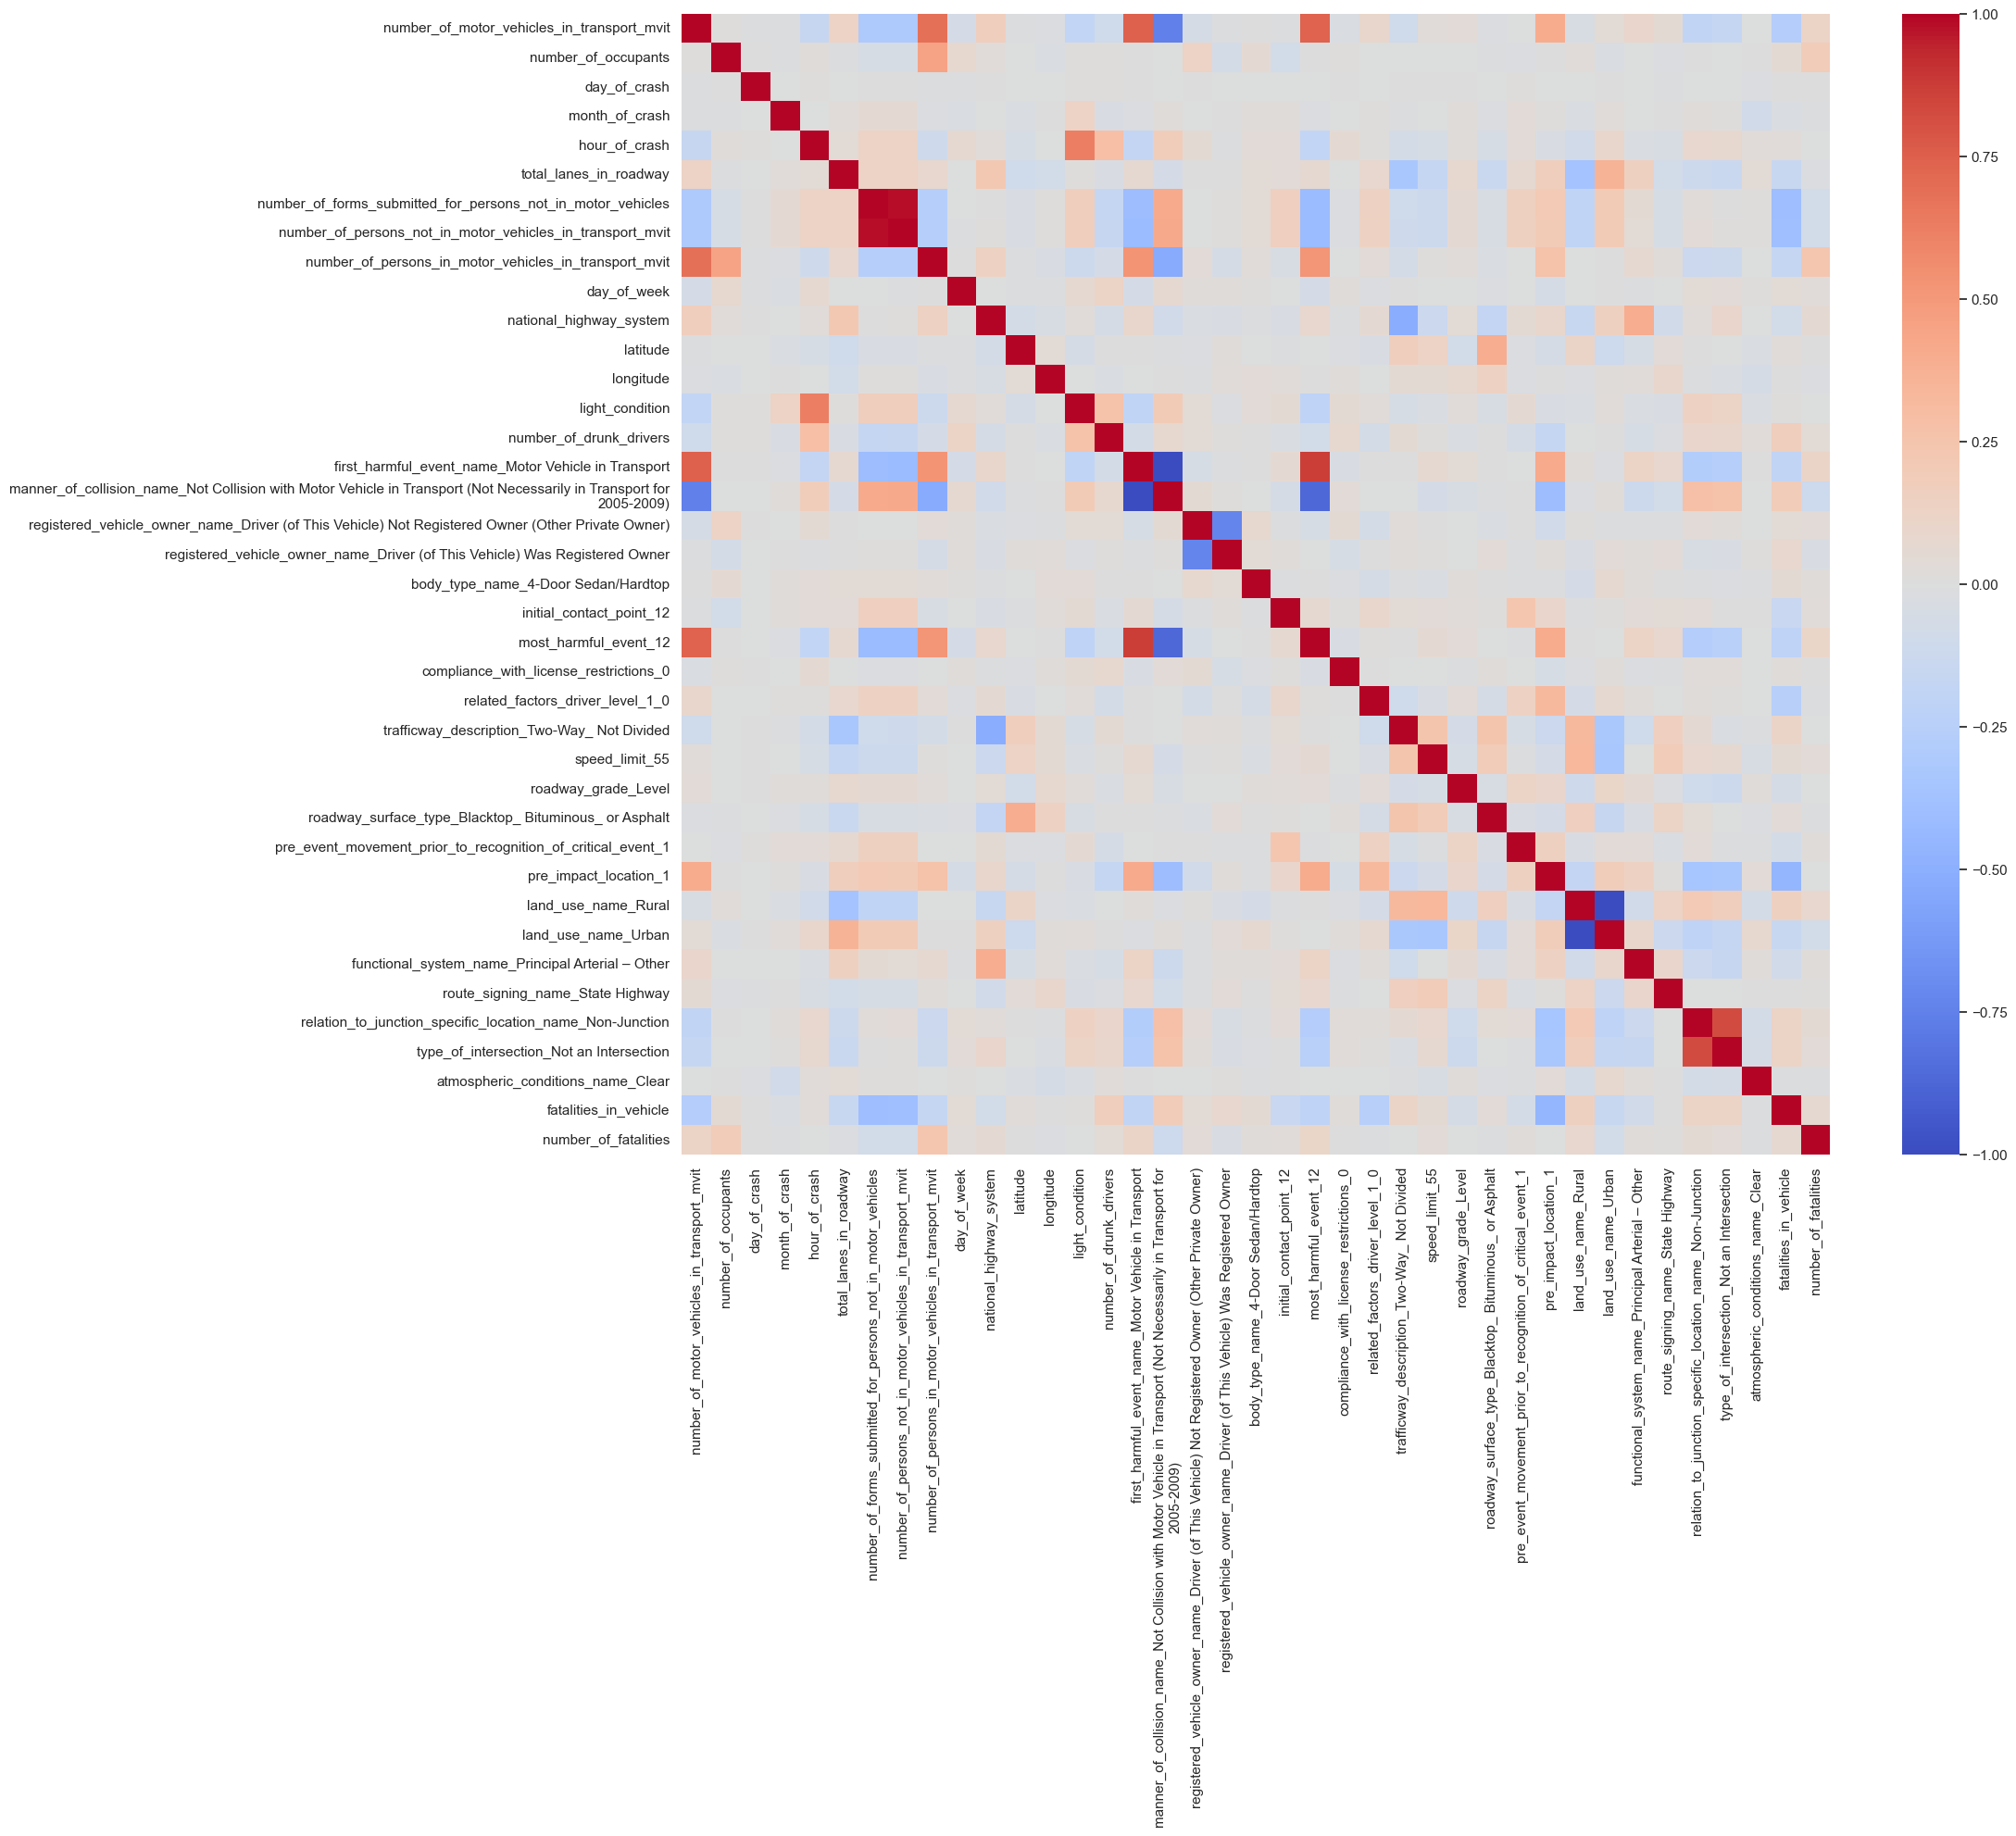

In [30]:
# print correlation matrix heat map
print_corr(pd.concat([X_vt, y_class, y_reg], axis=1), annotate=False)

In [31]:
# create another train-test split based on the variance threshold
X_train, X_test, y_train, y_test = train_test_split(X_vt, y_class, test_size=0.2, random_state=21)

In [32]:
# fit a model
xgb_model = XGBClassifier(objective='binary:logistic', n_jobs=-1)
xgb_model.fit(X_train, y_train)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [33]:
# save predictions from the test set
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

Classification report
               precision    recall  f1-score   support

       False       0.75      0.79      0.77      3439
        True       0.80      0.77      0.78      3833

    accuracy                           0.78      7272
   macro avg       0.78      0.78      0.78      7272
weighted avg       0.78      0.78      0.78      7272



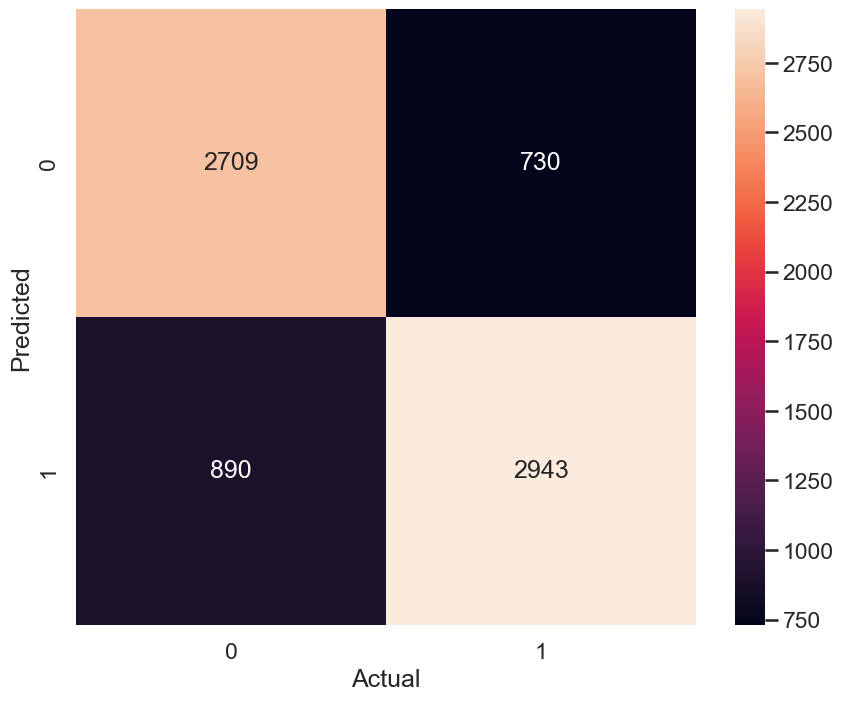

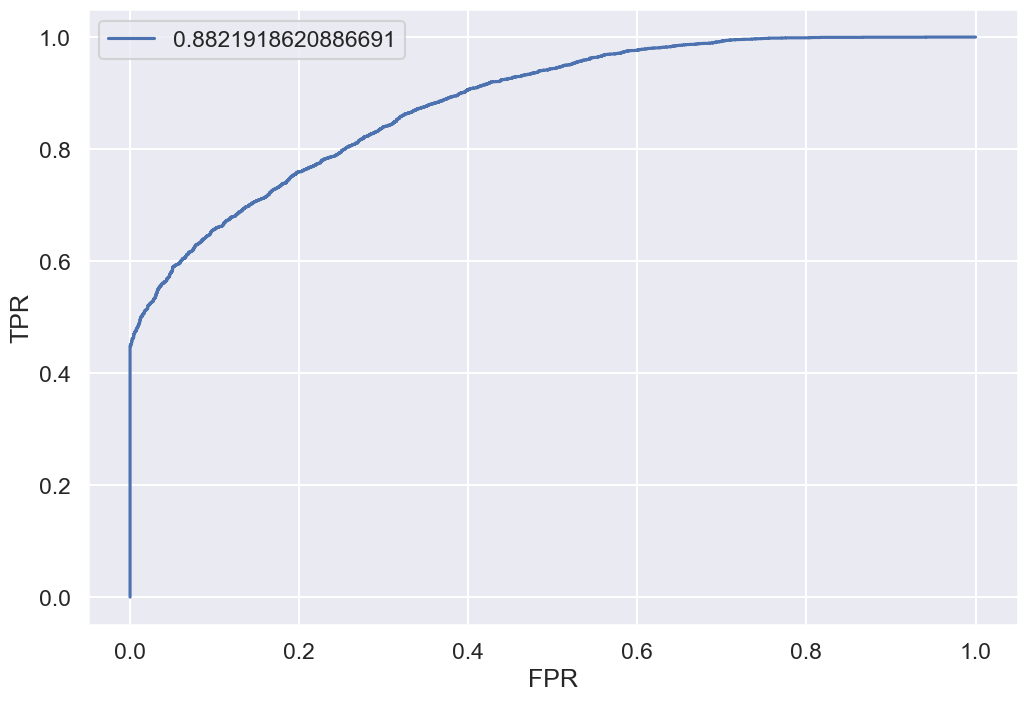

In [34]:
# evaluate the results
print('Classification report\n', classification_report(y_test, y_pred))
print_cm(y_test, y_pred)

# plot the ROC curve and print the AUC
print_roc_auc(y_test, y_pred_proba[:, 1])

## Model using random search and top 15 most important features

In [35]:
# create another train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_class, test_size=0.2, random_state=21)

In [36]:
# use random search to improve the model while simulatenously mitigating overfitting

# set up the parameter grid
params = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
          'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
          'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
          'gamma': [0, .01, 0.1, 0.25, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5],
          'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
          'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
          #'colsample_bylevel': [0.2, 0.4, 0.6, 0.8, 1.0],
          #'colsample_bynode': [0.2, 0.4, 0.6, 0.8, 1.0],
          'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
          'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
          'n_jobs':[-1],
          'objective':['binary:logistic']}

# 2nd set of parameters just in case the first set is too compute and/or memory heavy
params2 = {#'max_depth': [2, 5, 8],
          'learning_rate': [0.1, 0.01, 0.001],
          'n_estimators': [100, 500, 1000],
          'gamma': [0.01, 0.1],
          'min_child_weight': [1, 4, 7],
          'subsample': [0.5, 1.0],
          'colsample_bytree': [0.5, 1.0],
          #'colsample_bylevel': [0.2, 0.4, 0.6, 0.8, 1.0],
          #'colsample_bynode': [0.2, 0.4, 0.6, 0.8, 1.0],
          'reg_alpha': [0, 0.5, 1],
          'reg_lambda': [0, 0.5, 1],
          'n_jobs':[-1],
          'objective':['binary:logistic']}

In [37]:
# suppress future warnings to save on CPU cycles
warnings.filterwarnings('ignore', category=FutureWarning)

# initialize a second XGB classifier for grid search and do the grid search
xgb_model2 = XGBClassifier()

rs = RandomizedSearchCV(estimator=xgb_model2, param_distributions=params, cv=5, scoring='accuracy', n_iter=25, verbose=3, random_state=21)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, n_jobs=-1, objective=binary:logistic, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=0.782 total time=   0.3s
[CV 2/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, n_jobs=-1, objective=binary:logistic, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=0.798 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, n_jobs=-1, objective=binary:logistic, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=0.785 total time=   0.3s
[CV 4/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, n_jobs=-1, objective=binary:logistic, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=0.775 total time=   0.3s
[C

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'n_jobs': [-1],
                                        'objective': ['binary:logistic'],
                                        'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
                                        'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5,
                                                       3, 3.5, 4],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9, 1]},
                   random_state=21, scoring='accuracy', verbose=3)

In [38]:
# get the best parameters and the best score
print('Best score:', rs.best_score_)
print('Best parameters:', rs.best_params_)
best_xgb_params = rs.best_params_

Best score: 0.807618115086038
Best parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'objective': 'binary:logistic', 'n_jobs': -1, 'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.005, 'gamma': 2.5, 'colsample_bytree': 0.8}


In [39]:
# build a new model using the best parameters
xgb_best_model = XGBClassifier(**best_xgb_params)
xgb_best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=2.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.005, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

In [40]:
# make new predictions
y_best_pred = xgb_best_model.predict(X_test)
y_best_pred_proba = xgb_best_model.predict_proba(X_test)

Classification report
               precision    recall  f1-score   support

       False       0.78      0.82      0.80      3439
        True       0.83      0.80      0.81      3833

    accuracy                           0.81      7272
   macro avg       0.81      0.81      0.81      7272
weighted avg       0.81      0.81      0.81      7272



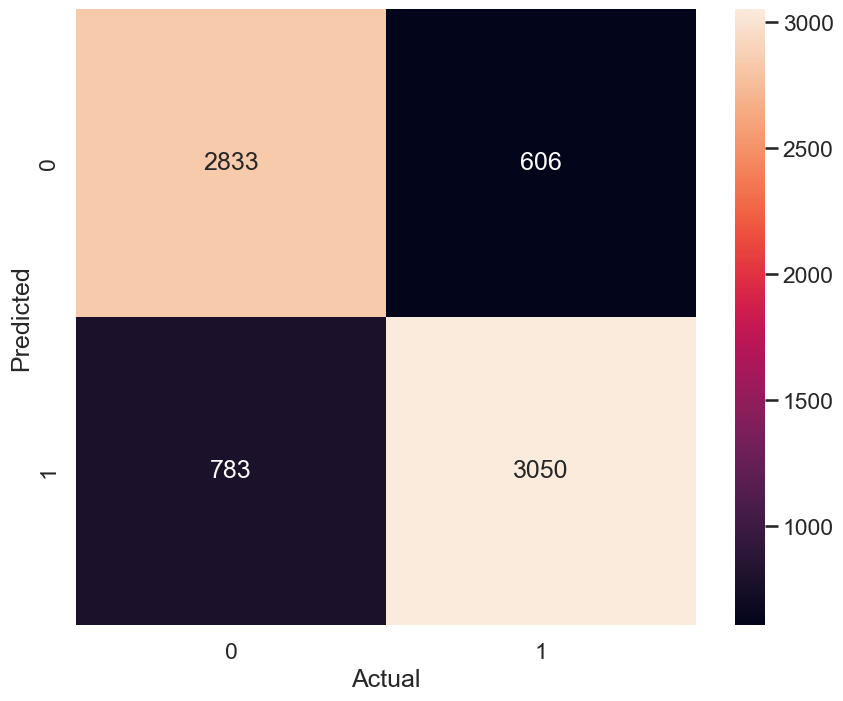

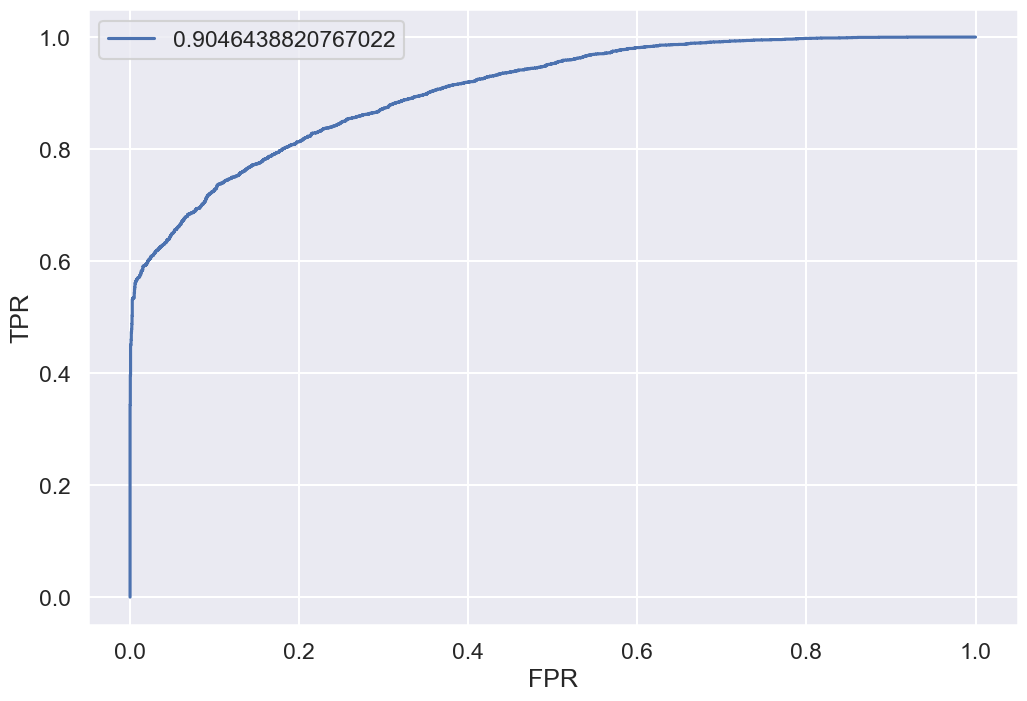

In [41]:
# evaluate this new model
print('Classification report\n', classification_report(y_test, y_best_pred))
print_cm(y_test, y_best_pred)
print_roc_auc(y_test, y_best_pred_proba[:, 1])

## Evaluation using 2016 data:

In [42]:
# import the 2016 formatted data for testing
df_2016 = pd.read_csv('../data/accident_vehicle_2016_formatted.csv')

In [43]:
rescaled_cols_2016 = scaler.transform(df_2016[cols_to_rescale])

# create a separate dataframe
df_2016_scaled = df_2016.drop((['fatalities_in_vehicle', 'number_of_fatalities']), axis=1).copy()
df_2016_scaled[cols_to_rescale] = rescaled_cols_2016.astype('float32')

In [44]:
# cosine transform the month, day of week and hour features since they're cyclical
df_2016_scaled['month_of_crash'] = np.cos(2 * np.pi * df_2016_scaled['month_of_crash'] / 12)
df_2016_scaled['day_of_week'] = np.cos(2 * np.pi * df_2016_scaled['day_of_week'] / 7)
df_2016_scaled['hour_of_crash'] = np.cos(2 * np.pi * df_2016_scaled['hour_of_crash'] / 24)

df_2016_scaled['month_of_crash'] = df_2016_scaled['month_of_crash'].astype('float32')
df_2016_scaled['day_of_week'] = df_2016_scaled['day_of_week'].astype('float32')
df_2016_scaled['hour_of_crash'] = df_2016_scaled['hour_of_crash'].astype('float32')

In [45]:
X_16 = df_2016_scaled[xgb_feats[:15]]
y_class_16 = df_2016['fatalities_in_vehicle']

In [46]:
# make new predictions
y_pred_16 = xgb_best_model.predict(X_16)
y_pred_proba_16 = xgb_best_model.predict_proba(X_16)

Classification report
               precision    recall  f1-score   support

       False       0.78      0.83      0.80     17420
        True       0.84      0.80      0.82     19788

    accuracy                           0.81     37208
   macro avg       0.81      0.81      0.81     37208
weighted avg       0.81      0.81      0.81     37208



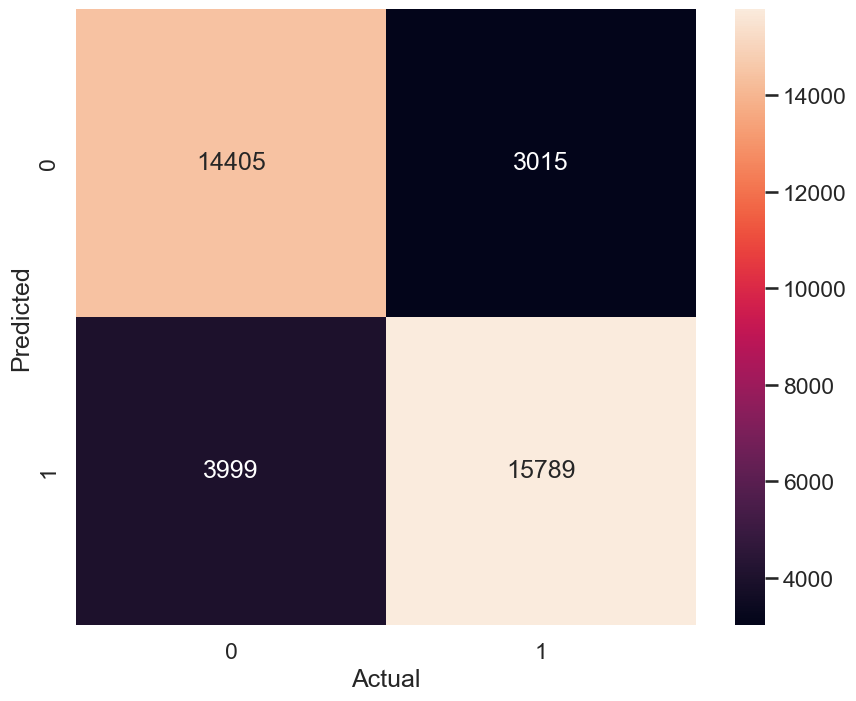

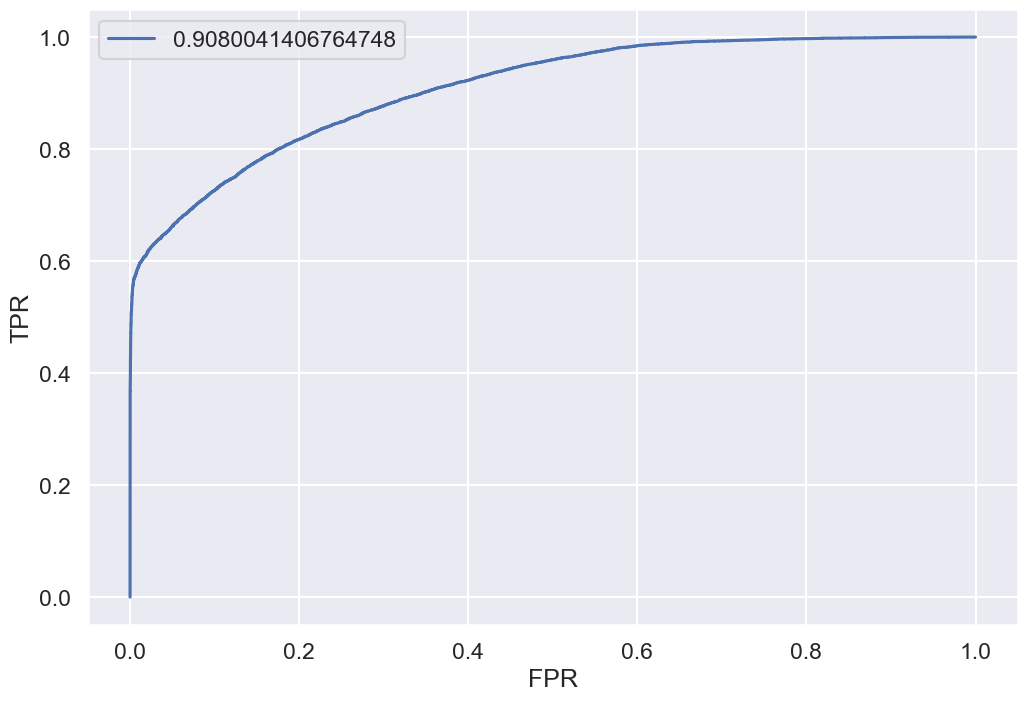

In [47]:
# evaluate this new model
print('Classification report\n', classification_report(y_class_16, y_pred_16))
print_cm(y_class_16, y_pred_16)
print_roc_auc(y_class_16, y_pred_proba_16[:, 1])

In [48]:
#create a separate dataframe to evaluate XGB model that uses all features
df_2016_scaled_all = df_2016_scaled.copy()

for col in df_scaled.columns:
    if col not in df_2016_scaled_all.columns:
        df_2016_scaled_all[col] = 0

Classification report
               precision    recall  f1-score   support

       False       0.87      0.88      0.87     17420
        True       0.89      0.89      0.89     19788

    accuracy                           0.88     37208
   macro avg       0.88      0.88      0.88     37208
weighted avg       0.88      0.88      0.88     37208



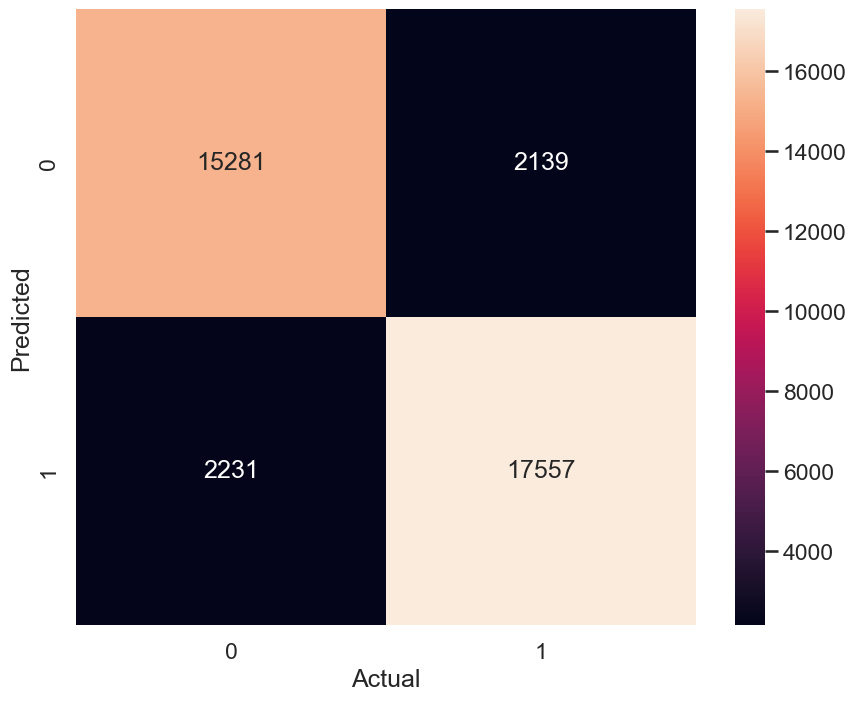

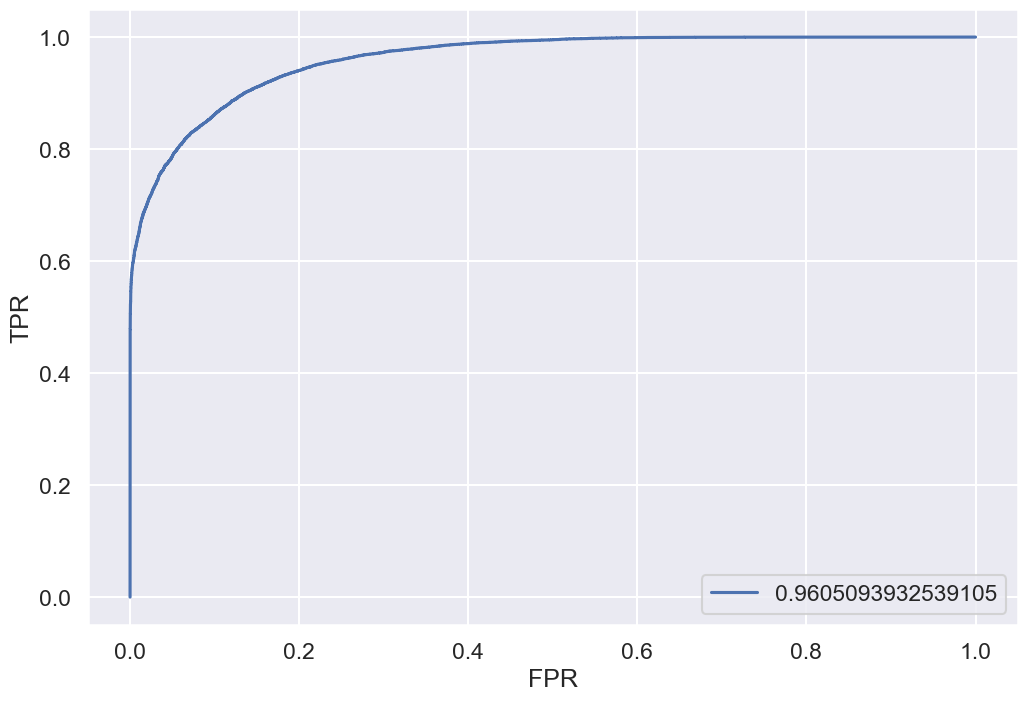

In [49]:
#evaluate model that was built using all features
y_pred_all_16 = xgb_all.predict(df_2016_scaled_all[df_scaled.columns])
y_pred_all_proba_16 = xgb_all.predict_proba(df_2016_scaled_all[df_scaled.columns])

print('Classification report\n', classification_report(y_class_16, y_pred_all_16))
print_cm(y_class_16, y_pred_all_16)
print_roc_auc(y_class_16, y_pred_all_proba_16[:, 1])